# Predicting the programming language of repos on Github
by Yvonne King and Daniel Guerrero

## Goal
Build a model that can predict what programming language a repository is, based on the text of the README file

In [146]:
from requests import get
from bs4 import BeautifulSoup
import os
import pandas as pd

import acquire
import prepare

import seaborn as sns

import matplotlib.pyplot as plt

import re
import nltk
import nltk.sentiment
from wordcloud import WordCloud

## Acquire
We ran the acquire.py file in 

In [2]:
df = pd.read_json("data.json")

In [3]:
df.shape

(248, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 3 columns):
repo               248 non-null object
language           215 non-null object
readme_contents    248 non-null object
dtypes: object(3)
memory usage: 5.9+ KB


In [5]:
df

,repo,language,readme_contents
0,vuejs/vue,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ..."
1,EbookFoundation/free-programming-books,None,This page is available as an easy-to-read webs...
2,tensorflow/tensorflow,C++,"<div align=""center"">\n <img src=""https://www...."
3,twbs/bootstrap,JavaScript,"<p align=""center"">\n <a href=""https://getboot..."
4,sindresorhus/awesome,None,"<div align=""center"">\n\t<img width=""500"" heigh..."
...,...,...,...
243,lodash/lodash,JavaScript,# lodash\n\n[Site](https://lodash.com/) |\n[Do...
244,josephmisiti/awesome-machine-learning,Python,# Awesome Machine Learning [![Awesome](https:/...
245,kdn251/interviews,Java,> * 原文地址：[github.com/kdn251/interviews](https:...
246,h5bp/Front-end-Developer-Interview-Questions,HTML,# Front-end Job Interview Questions\n\nThis re...


## Prep
Using the prep_readme_function we will:
- normalize data by removing non ASCII characters
- tokenize words
- stem and lemmatize words
- remove stop words

In [6]:
def prep_readme_data(df):
    '''
    This function takes in the github readme df and
    returns the df with original columns plus cleaned
    and lemmatized content without stopwords.
    '''
    # Do basic clean on article content
    df = prepare.basic_clean(df, 'readme_contents')
    
    # Tokenize clean article content
    df = prepare.tokenize(df, 'basic_clean')
    
    # Lemmatize cleaned and tokenized article content
    df = prepare.lemmatize(df, 'clean_tokes')
    
    # Remove stopwords from Lemmatized article content
    df = prepare.remove_stopwords(df, 'lemmatized')
    
    return df[['repo', 'language', 'readme_contents', 'clean_tokes', 'clean_lemmatized']]

In [7]:
prep_readme_data(df)

,repo,language,readme_contents,clean_tokes,clean_lemmatized
0,vuejs/vue,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ...","[p, aligncentera, hrefhttpsvuejsorg, target_bl...",p aligncentera hrefhttpsvuejsorg target_blank ...
1,EbookFoundation/free-programming-books,None,This page is available as an easy-to-read webs...,"[this, page, is, available, as, an, easytoread...",page available easytoread website httpsebookfo...
2,tensorflow/tensorflow,C++,"<div align=""center"">\n <img src=""https://www....","[div, aligncenter, img, srchttpswwwtensorflowo...",div aligncenter img srchttpswwwtensorfloworgim...
3,twbs/bootstrap,JavaScript,"<p align=""center"">\n <a href=""https://getboot...","[p, aligncenter, a, hrefhttpsgetbootstrapcom, ...",p aligncenter hrefhttpsgetbootstrapcom img src...
4,sindresorhus/awesome,None,"<div align=""center"">\n\t<img width=""500"" heigh...","[div, aligncenter, &#9;, img, width500, height...",div aligncenter &#9; img width500 height350 sr...
...,...,...,...,...,...
243,lodash/lodash,JavaScript,# lodash\n\n[Site](https://lodash.com/) |\n[Do...,"[lodash, sitehttpslodashcom, docshttpslodashco...",lodash sitehttpslodashcom docshttpslodashcomdo...
244,josephmisiti/awesome-machine-learning,Python,# Awesome Machine Learning [![Awesome](https:/...,"[awesome, machine, learning, awesomehttpscdnra...",awesome machine learning awesomehttpscdnrawgit...
245,kdn251/interviews,Java,> * 原文地址：[github.com/kdn251/interviews](https:...,[githubcomkdn251interviewshttpsgithubcomkdn251...,githubcomkdn251interviewshttpsgithubcomkdn251i...
246,h5bp/Front-end-Developer-Interview-Questions,HTML,# Front-end Job Interview Questions\n\nThis re...,"[frontend, job, interview, questions, this, re...",frontend job interview question repository con...


In [8]:
df = prepare.prep_readme_data(df)

In [9]:
df

,repo,language,readme_contents,clean_tokes,clean_lemmatized
0,vuejs/vue,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ...","[p, aligncentera, hrefhttpsvuejsorg, target_bl...",p aligncentera hrefhttpsvuejsorg target_blank ...
1,EbookFoundation/free-programming-books,None,This page is available as an easy-to-read webs...,"[this, page, is, available, as, an, easytoread...",page available easytoread website httpsebookfo...
2,tensorflow/tensorflow,C++,"<div align=""center"">\n <img src=""https://www....","[div, aligncenter, img, srchttpswwwtensorflowo...",div aligncenter img srchttpswwwtensorfloworgim...
3,twbs/bootstrap,JavaScript,"<p align=""center"">\n <a href=""https://getboot...","[p, aligncenter, a, hrefhttpsgetbootstrapcom, ...",p aligncenter hrefhttpsgetbootstrapcom img src...
4,sindresorhus/awesome,None,"<div align=""center"">\n\t<img width=""500"" heigh...","[div, aligncenter, &#9;, img, width500, height...",div aligncenter &#9; img width500 height350 sr...
...,...,...,...,...,...
243,lodash/lodash,JavaScript,# lodash\n\n[Site](https://lodash.com/) |\n[Do...,"[lodash, sitehttpslodashcom, docshttpslodashco...",lodash sitehttpslodashcom docshttpslodashcomdo...
244,josephmisiti/awesome-machine-learning,Python,# Awesome Machine Learning [![Awesome](https:/...,"[awesome, machine, learning, awesomehttpscdnra...",awesome machine learning awesomehttpscdnrawgit...
245,kdn251/interviews,Java,> * 原文地址：[github.com/kdn251/interviews](https:...,[githubcomkdn251interviewshttpsgithubcomkdn251...,githubcomkdn251interviewshttpsgithubcomkdn251i...
246,h5bp/Front-end-Developer-Interview-Questions,HTML,# Front-end Job Interview Questions\n\nThis re...,"[frontend, job, interview, questions, this, re...",frontend job interview question repository con...


In [10]:
len(df.readme_contents[1])

4769

In [11]:
df.language.value_counts(), df.language.value_counts(normalize=True)

(JavaScript          73
 Python              27
 Java                20
 TypeScript          17
 C++                 12
 Go                  12
 C                    6
 Swift                5
 Rust                 4
 HTML                 4
 PHP                  4
 Vue                  4
 Shell                4
 Ruby                 3
 Kotlin               3
 CSS                  3
 Dart                 2
 Clojure              2
 Objective-C          2
 Jupyter Notebook     2
 Assembly             1
 C#                   1
 OCaml                1
 TeX                  1
 Haskell              1
 Emacs Lisp           1
 Name: language, dtype: int64, JavaScript          0.339535
 Python              0.125581
 Java                0.093023
 TypeScript          0.079070
 C++                 0.055814
 Go                  0.055814
 C                   0.027907
 Swift               0.023256
 Rust                0.018605
 HTML                0.018605
 PHP                 0.018605
 Vue            

In [12]:
#drop the none data frames
df = df[(~df.readme_contents.str.contains("<p ")) & (~df.readme_contents.str.contains("<div "))].dropna()

## Distro of Data

In [13]:
# Quick dataframe to view the distribution of languages
pd.concat(
    [df.language.value_counts(), df.language.value_counts(normalize=True)], axis=1
    ).set_axis(['n', 'percent'], axis=1, inplace=False)

,n,percent
JavaScript,45,0.292208
Python,21,0.136364
Java,17,0.110390
Go,11,0.071429
C++,11,0.071429
TypeScript,10,0.064935
C,6,0.038961
HTML,4,0.025974
Ruby,3,0.019481
Rust,3,0.019481


In [14]:
value_counts = pd.DataFrame(df.language.value_counts(ascending=False))
value_counts[:5]

,language
JavaScript,45
Python,21
Java,17
Go,11
C++,11


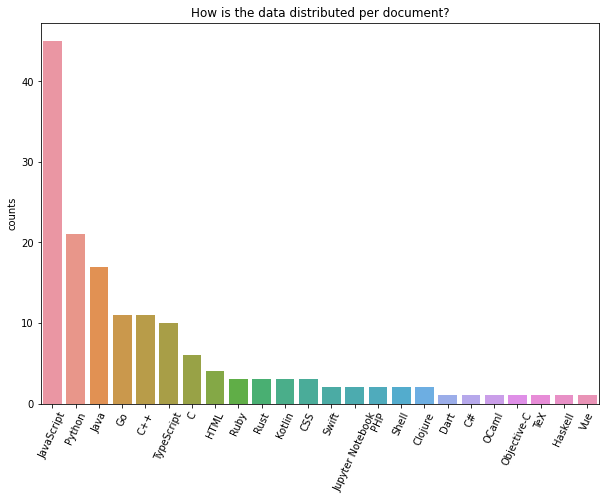

In [15]:
plt.figure(figsize=(10,7))
bar = sns.barplot(x=value_counts.index, y="language", data=value_counts)
bar.set_xticklabels(bar.get_xticklabels(),rotation=65)
bar.set_ylabel("counts")

plt.title("How is the data distributed per document?")
plt.show()

Question 1: Does the length of the README vary by programming language?

In [16]:
#look at the lengths per readme so we can compare by language
df_length = df.assign(length = df.clean_lemmatized.apply(len))

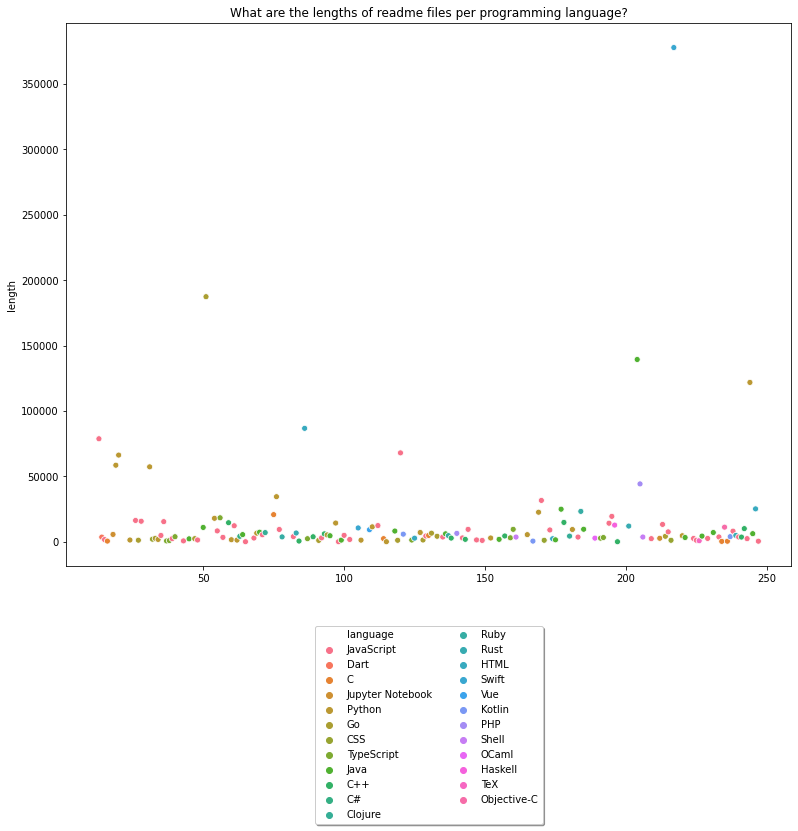

In [17]:
plt.figure(figsize=(13,10))
ax = plt.subplot(111)

plt.title("What are the lengths of readme files per programming language?")
sns.scatterplot(y=df_length.length, x=df_length.index,hue=df_length.language)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=2)
plt.show()

Takeaways
- It looks like most readmes have under 25k characters
- Pyhton and Swift seem to have a few outliers

### Lets take a look at the medians, min, and max

In [18]:
median_lengths = df_length.groupby("language").median().sort_values(by="length", ascending= False)
max_length = pd.DataFrame(df_length.groupby("language").length.max().sort_values(ascending= False))
min_length = pd.DataFrame(df_length.groupby("language").length.min().sort_values(ascending= False))

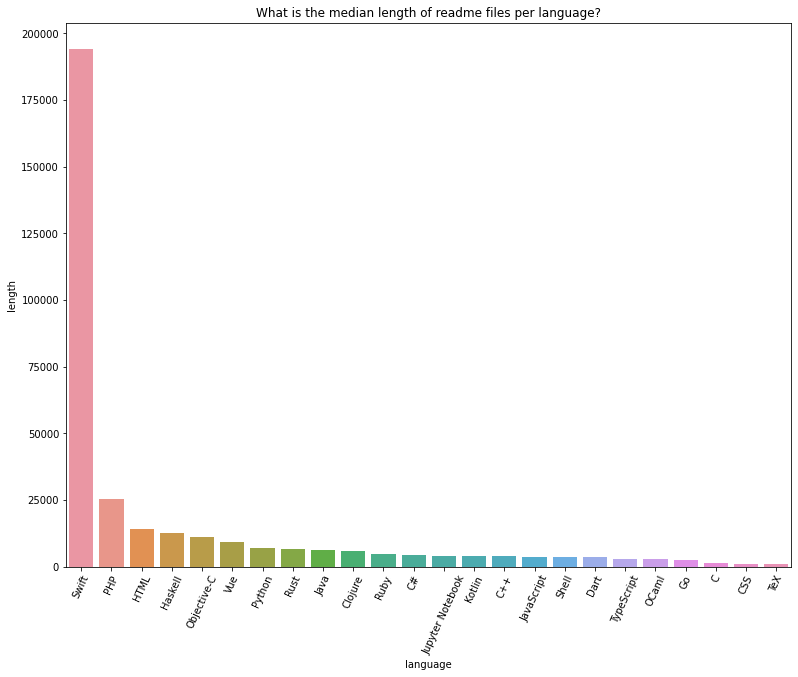

In [19]:
plt.figure(figsize=(13,10))
plt.title("What is the median length of readme files per language?")
bar = sns.barplot(y=median_lengths.length,x=median_lengths.index)

bar.set_xticklabels(bar.get_xticklabels(),rotation=65)
plt.show()

Takeaways:
- Swift has the highest median but this is most likely because of the outlier we found in the scatterplot

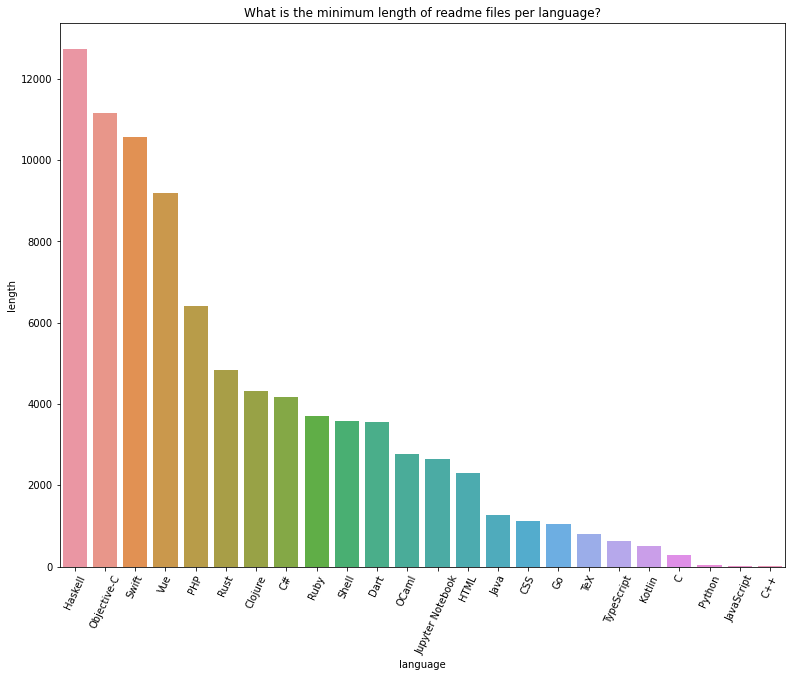

In [20]:
plt.figure(figsize=(13,10))
plt.title("What is the minimum length of readme files per language?")
bar = sns.barplot(y=min_length.length,x=min_length.index)

bar.set_xticklabels(bar.get_xticklabels(),rotation=65)
plt.show()

Takeaways:
- Haskell has the highest min lenght of readmes and Pyhton, JavaScript and C++ have the lowest.

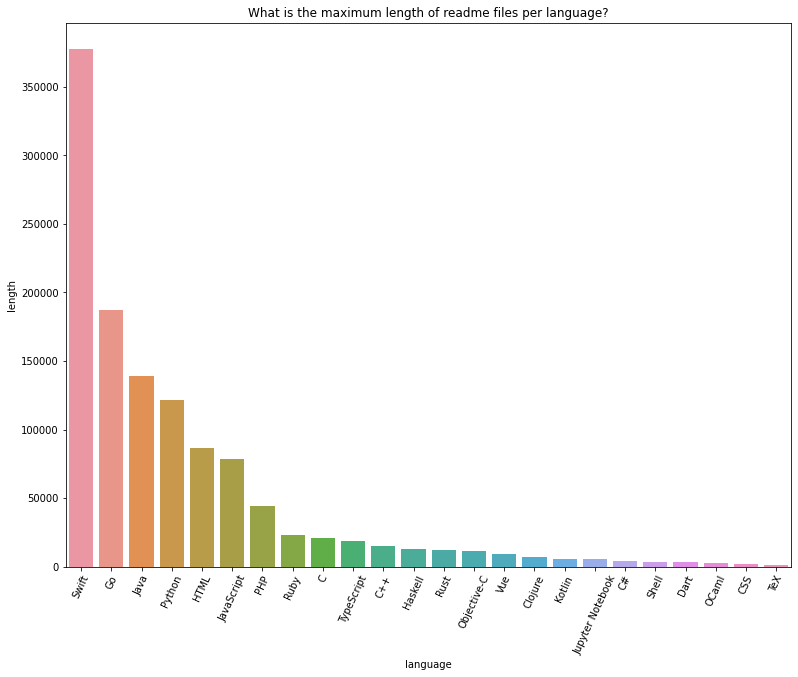

In [21]:
plt.figure(figsize=(13,10))
plt.title("What is the maximum length of readme files per language?")
bar = sns.barplot(y=max_length.length,x=max_length.index)

bar.set_xticklabels(bar.get_xticklabels(),rotation=65)
plt.show()

Takeaways:
- Again here we see that swift is leading the pack with the max length

Question: Do different programming languages use a different number of unique words?

In [22]:
#Our top five languages
value_counts[:5]

,language
JavaScript,45
Python,21
Java,17
Go,11
C++,11


In [23]:
small_df = df[["language", "readme_contents"]]

In [24]:
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (text.encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split() # tokenization
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [25]:
all_words = clean(" ".join(small_df.readme_contents))
javascript_words = clean(" ".join(small_df[small_df.language == "JavaScript"].readme_contents))
pyhton_words = clean(" ".join(small_df[small_df.language == "Python"].readme_contents))
java_words = clean(" ".join(small_df[small_df.language == "Java"].readme_contents))
go_words = clean(" ".join(small_df[small_df.language == "Go"].readme_contents))
cplus_words = clean(" ".join(small_df[small_df.language == "C++"].readme_contents))

In [26]:
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=14)

In [27]:
pd.Series(javascript_words).nunique()

9835

In [28]:
pd.Series(pyhton_words).nunique()

10870

In [29]:
pd.Series(java_words).nunique()

6657

In [30]:
pd.Series(go_words).nunique()

6546

In [31]:
pd.Series(cplus_words).nunique()

2130

In [41]:
df

,repo,language,readme_contents,clean_tokes,clean_lemmatized
13,airbnb/javascript,JavaScript,# Airbnb JavaScript Style Guide() {\n\n*A most...,"[airbnb, javascript, style, guide, a, mostly, ...",airbnb javascript style guide mostly reasonabl...
14,flutter/flutter,Dart,# [![Flutter logo][]][flutter.dev]\n\n[![Build...,"[flutter, logoflutterdev, build, status, cirru...",flutter logoflutterdev build status cirrusbuil...
15,d3/d3,JavaScript,"# D3: Data-Driven Documents\n\n<a href=""https:...","[d3, datadriven, documents, a, hrefhttpsd3jsor...",d3 datadriven document hrefhttpsd3jsorgimg src...
16,torvalds/linux,C,Linux kernel\n============\n\nThere are severa...,"[linux, kernel, there, are, several, guides, f...",linux kernel several guide kernel developer us...
18,jackfrued/Python-100-Days,Jupyter Notebook,## Python - 100天从新手到大师\n\n> **作者**：骆昊\n>\n> **...,"[python, 100, 8w15pythoncore50courseshttpsgith...",python 100 8w15pythoncore50courseshttpsgithubc...
...,...,...,...,...,...
243,lodash/lodash,JavaScript,# lodash\n\n[Site](https://lodash.com/) |\n[Do...,"[lodash, sitehttpslodashcom, docshttpslodashco...",lodash sitehttpslodashcom docshttpslodashcomdo...
244,josephmisiti/awesome-machine-learning,Python,# Awesome Machine Learning [![Awesome](https:/...,"[awesome, machine, learning, awesomehttpscdnra...",awesome machine learning awesomehttpscdnrawgit...
245,kdn251/interviews,Java,> * 原文地址：[github.com/kdn251/interviews](https:...,[githubcomkdn251interviewshttpsgithubcomkdn251...,githubcomkdn251interviewshttpsgithubcomkdn251i...
246,h5bp/Front-end-Developer-Interview-Questions,HTML,# Front-end Job Interview Questions\n\nThis re...,"[frontend, job, interview, questions, this, re...",frontend job interview question repository con...


Takeaways:
- looks like Pyhton uses the most number of unique words

In [55]:
javascript = df[small_df.language == "JavaScript"]
pyhton = df[small_df.language == "Python"]
java = df[small_df.language == "Java"]
cplus = df[small_df.language == "C++"]

In [84]:
df.loc[(df.language != "Python") & (df.language !="Java") & (df.language !="JavaScript") & (df.language !="C++"), 'is_top_language'] = 'other'
df.is_top_language = df.is_top_language.fillna(df.language)

In [77]:
word = "jfnjkf kdflgjfdkl kdalfgkldfn sdlkgndlksn"

In [80]:
def word_count(word):
    word_count = len(re.findall(r'\w+', word))
    return word_count

In [96]:
df["word_count"] = df.clean_lemmatized.apply(word_count)

In [97]:
df

,repo,language,readme_contents,clean_tokes,clean_lemmatized,is_top_language,word_count
13,airbnb/javascript,JavaScript,# Airbnb JavaScript Style Guide() {\n\n*A most...,"[airbnb, javascript, style, guide, a, mostly, ...",airbnb javascript style guide mostly reasonabl...,JavaScript,7587
14,flutter/flutter,Dart,# [![Flutter logo][]][flutter.dev]\n\n[![Build...,"[flutter, logoflutterdev, build, status, cirru...",flutter logoflutterdev build status cirrusbuil...,other,309
15,d3/d3,JavaScript,"# D3: Data-Driven Documents\n\n<a href=""https:...","[d3, datadriven, documents, a, hrefhttpsd3jsor...",d3 datadriven document hrefhttpsd3jsorgimg src...,JavaScript,153
16,torvalds/linux,C,Linux kernel\n============\n\nThere are severa...,"[linux, kernel, there, are, several, guides, f...",linux kernel several guide kernel developer us...,other,58
18,jackfrued/Python-100-Days,Jupyter Notebook,## Python - 100天从新手到大师\n\n> **作者**：骆昊\n>\n> **...,"[python, 100, 8w15pythoncore50courseshttpsgith...",python 100 8w15pythoncore50courseshttpsgithubc...,other,581
...,...,...,...,...,...,...,...
243,lodash/lodash,JavaScript,# lodash\n\n[Site](https://lodash.com/) |\n[Do...,"[lodash, sitehttpslodashcom, docshttpslodashco...",lodash sitehttpslodashcom docshttpslodashcomdo...,JavaScript,177
244,josephmisiti/awesome-machine-learning,Python,# Awesome Machine Learning [![Awesome](https:/...,"[awesome, machine, learning, awesomehttpscdnra...",awesome machine learning awesomehttpscdnrawgit...,Python,10258
245,kdn251/interviews,Java,> * 原文地址：[github.com/kdn251/interviews](https:...,[githubcomkdn251interviewshttpsgithubcomkdn251...,githubcomkdn251interviewshttpsgithubcomkdn251i...,Java,461
246,h5bp/Front-end-Developer-Interview-Questions,HTML,# Front-end Job Interview Questions\n\nThis re...,"[frontend, job, interview, questions, this, re...",frontend job interview question repository con...,other,1379


In [111]:
min_word_count = pd.DataFrame(df.groupby("is_top_language").word_count.min())
min_word_count.columns = ['Min Word Count']

max_word_count = pd.DataFrame(df.groupby("is_top_language").word_count.max())
max_word_count.columns = ["Max Word Count"]

median_word_count = pd.DataFrame(df.groupby("is_top_language").word_count.median())
median_word_count.columns = ["Median Word Count"]

mean_word_count = pd.DataFrame(df.groupby("is_top_language").word_count.mean())
mean_word_count.columns = ["Mean Word Count"]

std_word_count = pd.DataFrame(df.groupby("is_top_language").word_count.std())
std_word_count.columns = ["STD of Word Count"]

In [112]:
summary1 = pd.merge(min_word_count, max_word_count, left_index=True, right_index=True)
summary2 = pd.merge(median_word_count , mean_word_count , left_index=True, right_index=True)
summary3 = pd.merge(summary1 , summary2 , left_index=True, right_index=True)
summary = pd.merge(summary3 , std_word_count , left_index=True, right_index=True)

In [113]:
summary

,Min Word Count,Max Word Count,Median Word Count,Mean Word Count,STD of Word Count
is_top_language,,,,,
C++,2,1713,289.0,513.363636,547.816442
Java,124,10851,389.0,1006.235294,2544.756509
JavaScript,1,7587,370.0,807.666667,1324.018230
Python,3,10258,801.0,2093.285714,2803.159631
other,37,21339,333.5,1321.033333,3613.523896


In [ ]:
plt.figure(figsize=(13,10))
plt.title("What is the maximum length of readme files per language?")
bar = sns.barplot(y=max_length.length,x=max_length.index)

bar.set_xticklabels(bar.get_xticklabels(),rotation=65)
plt.show()

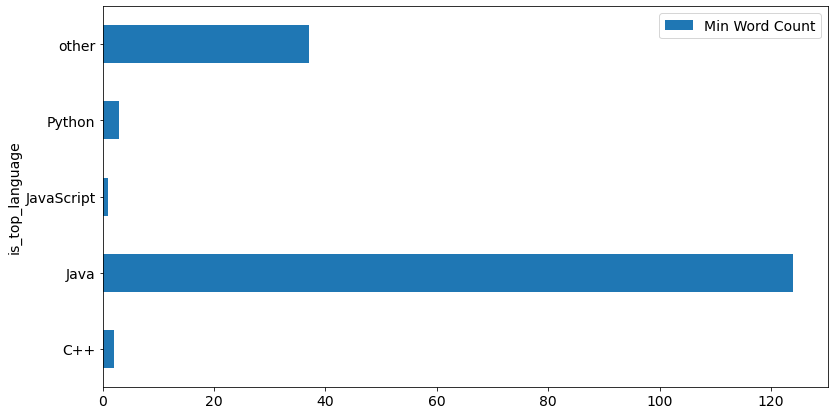

In [120]:
min_word_count.plot.barh()

In [68]:
javascript.clean_tokes[:1]

13    [airbnb, javascript, style, guide, a, mostly, ...
Name: clean_tokes, dtype: object

In [89]:
def word_freq(dfx, language="language", cleaned="clean_lemmatized"):
    # create list of words by language

    js_words = ' '.join(dfx[dfx[language] == 'JavaScript'][cleaned]).split()
    p_words = ' '.join(dfx[dfx[language] == 'Python'][cleaned]).split()
    j_words = ' '.join(dfx[dfx[language] == 'Java'][cleaned]).split()
    php_words = ' '.join(dfx[dfx[language] == 'PHP'][cleaned]).split()
    go_words = ' '.join(dfx[dfx[language] == 'Go'][cleaned]).split()
    jup_words = ' '.join(dfx[dfx[language] == 'Jupyter Notebook'][cleaned]).split()
    html_words = ' '.join(dfx[dfx[language] == 'HTML'][cleaned]).split()
    swift_words = ' '.join(dfx[dfx[language] == 'Swift'][cleaned]).split()
    ts_words = ' '.join(dfx[dfx[language] == 'TypeScript'][cleaned]).split()
    ruby_words = ' '.join(dfx[dfx[language]== 'Ruby'][cleaned]).split()
    cpp_words = ' '.join(dfx[dfx[language] == 'C++'][cleaned]).split()
    css_words = ' '.join(dfx[dfx[language] == 'CSS'][cleaned]).split()
    shell_words = ' '.join(dfx[dfx[language] == 'Shell'][cleaned]).split()
    c_words = ' '.join(dfx[dfx[language] == 'C'][cleaned]).split()
    csharp_words = ' '.join(dfx[dfx[language] == 'C#'][cleaned]).split()
    all_words = ' '.join(dfx[cleaned]).split()

    # create Series of word frequency by language

    js_freq = pd.Series(js_words).value_counts()
    p_freq = pd.Series(p_words).value_counts()
    j_freq = pd.Series(j_words).value_counts()
    php_freq = pd.Series(php_words).value_counts()
    go_freq = pd.Series(go_words).value_counts()
    jup_freq = pd.Series(jup_words).value_counts()
    html_freq = pd.Series(html_words).value_counts()
    swift_freq = pd.Series(swift_words).value_counts()
    ts_freq = pd.Series(ts_words).value_counts()
    ruby_freq = pd.Series(ruby_words).value_counts()
    cpp_freq = pd.Series(cpp_words).value_counts()
    css_freq = pd.Series(css_words).value_counts()
    shell_freq = pd.Series(shell_words).value_counts()
    c_freq = pd.Series(c_words).value_counts()
    csharp_freq = pd.Series(csharp_words).value_counts()
    all_freq = pd.Series(all_words).value_counts()

    # Combine Series' together into df
    word_counts = (pd.concat([all_freq, js_freq, p_freq, j_freq, php_freq, go_freq, jup_freq, html_freq, swift_freq, ts_freq, ruby_freq, cpp_freq, css_freq, c_freq, csharp_freq], axis=1, sort=True)
     .set_axis(['all', 'javascript', 'python', 'java', 'php', 'go', 'jupyter_notebook', 'html', 'swift', 'typescript', 'ruby', 'C+', 'CSS', 'C', 'C#'], axis=1, inplace=False)
     .fillna(0)
     .apply(lambda s: s.astype(int)))
    
    return word_counts

In [123]:
def word_freq(dfx, language="is_top_language", cleaned="clean_lemmatized"):
    # create list of words by language

    js_words = ' '.join(dfx[dfx[language] == 'JavaScript'][cleaned]).split()
    p_words = ' '.join(dfx[dfx[language] == 'Python'][cleaned]).split()
    j_words = ' '.join(dfx[dfx[language] == 'Java'][cleaned]).split()
    cpp_words = ' '.join(dfx[dfx[language] == 'C++'][cleaned]).split()
    other_words = ' '.join(dfx[dfx[language] == 'other'][cleaned]).split()
    all_words = ' '.join(dfx[cleaned]).split()
    
    return js_words, p_words, j_words, cpp_words, other_words, all_words

In [124]:
js_words, p_words, j_words, cpp_words, other_words, all_words = word_freq(df, language="is_top_language", cleaned="clean_lemmatized")

# Bigrams

In [130]:
top_20_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(20))

top_20_js_bigrams = (pd.Series(nltk.ngrams(js_words, 2))
                      .value_counts()
                      .head(20))

top_20_p_bigrams = (pd.Series(nltk.ngrams(p_words, 2))
                      .value_counts()
                      .head(20))

top_20_j_bigrams = (pd.Series(nltk.ngrams(j_words, 2))
                      .value_counts()
                      .head(20))

top_20_cpp_bigrams = (pd.Series(nltk.ngrams(cpp_words, 2))
                      .value_counts()
                      .head(20))

top_20_other_bigrams = (pd.Series(nltk.ngrams(other_words, 2))
                      .value_counts()
                      .head(20))

In [131]:
top_20_bigrams

(detail, &#9;)                                      879
(summary, &#9;)                                     878
(&#9;, added)                                       750
(&#9;, summarycodeswiftcode)                        513
(1codea, detail)                                    457
(yes, unknown)                                      439
(license, mithttpchoosealicensecomlicensesmitbr)    376
(mithttpchoosealicensecomlicensesmitbr, &#9;)       376
(2016br, license)                                   284
(summarycodeswiftcode, summary)                     279
(machine, learning)                                 267
(apikey, yes)                                       225
(jupyter, notebook)                                 215
(&#9;, summarycodeobjccode)                         192
(license, otherbr)                                  188
(otherbr, &#9;)                                     188
(open, source)                                      186
(2015br, license)                               

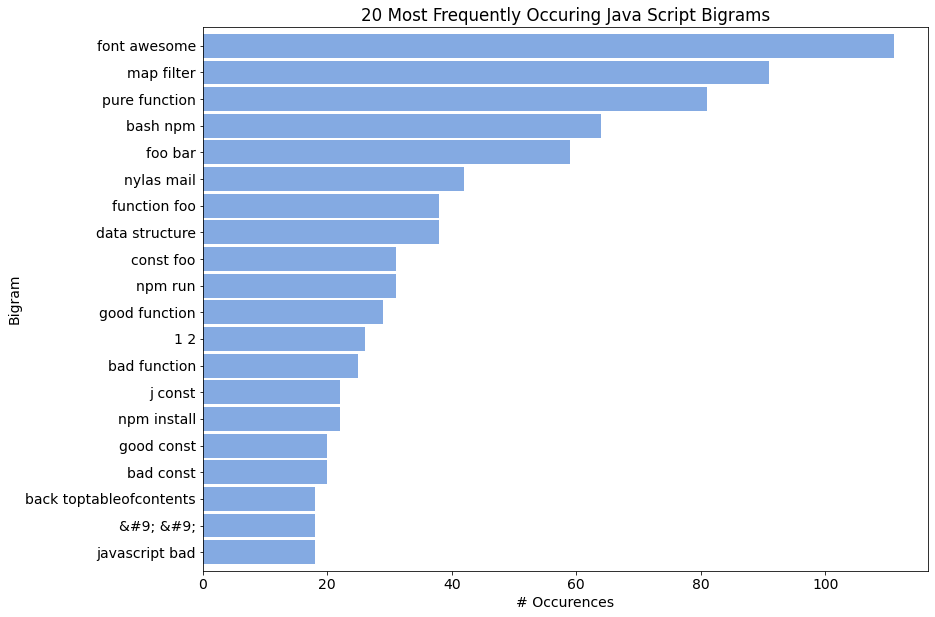

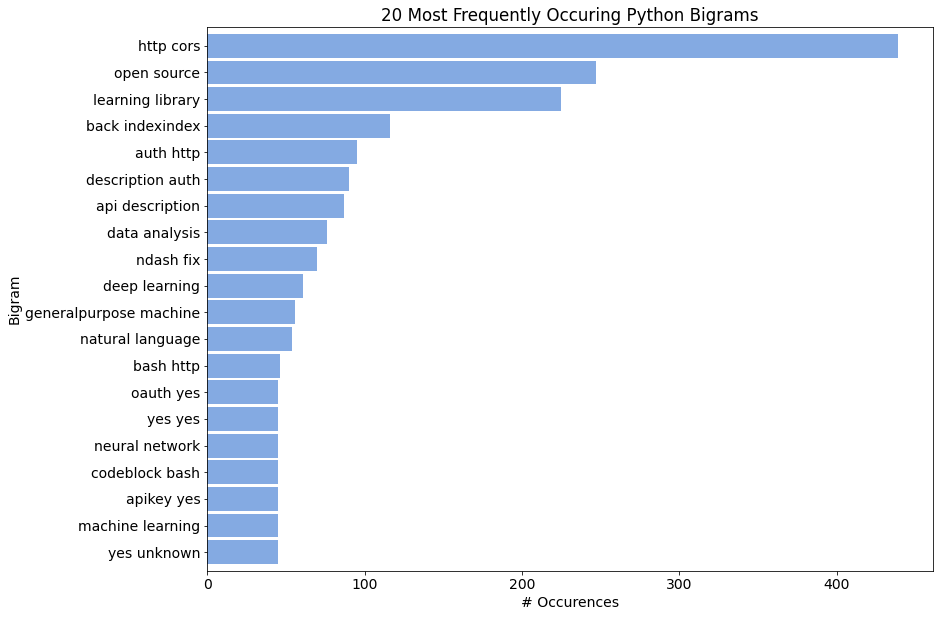

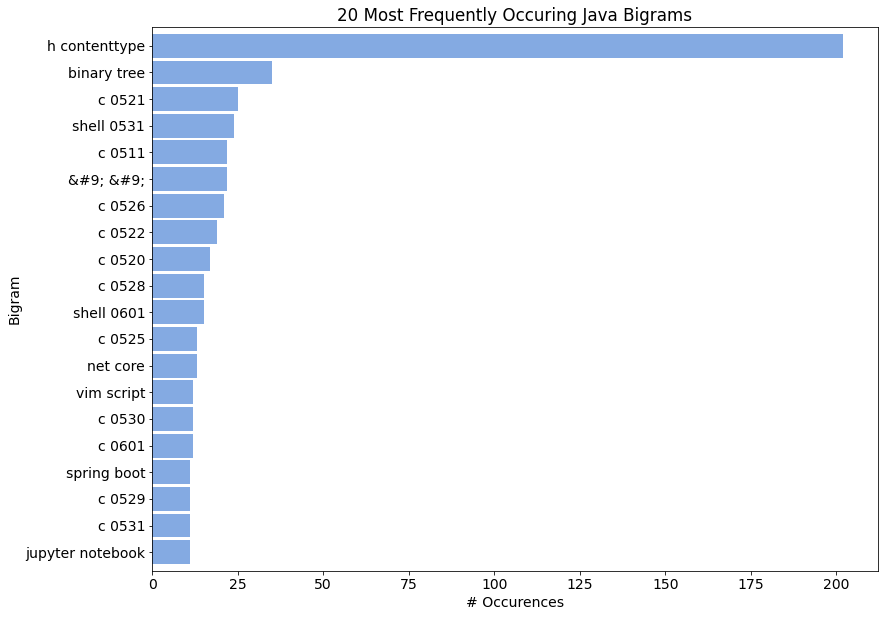

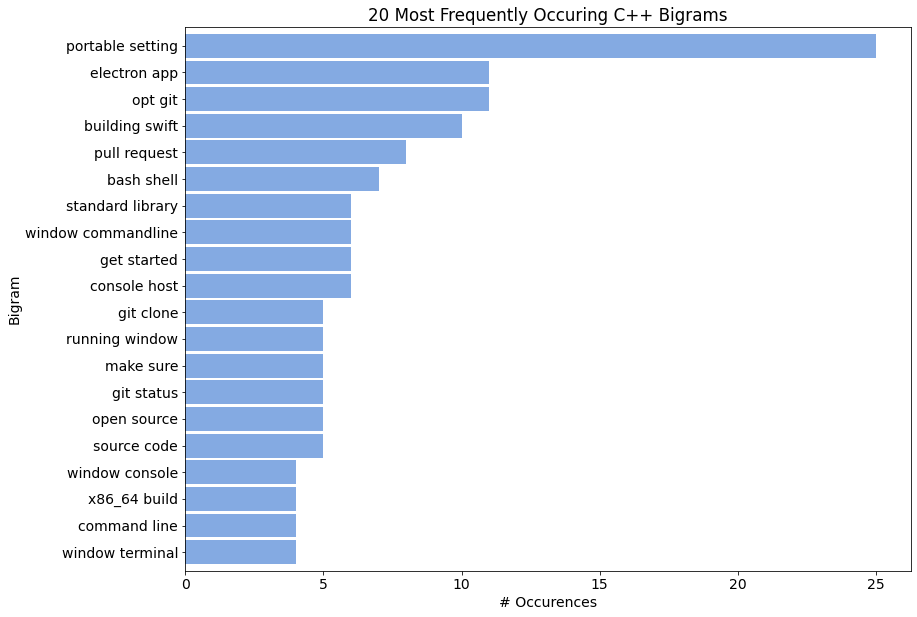

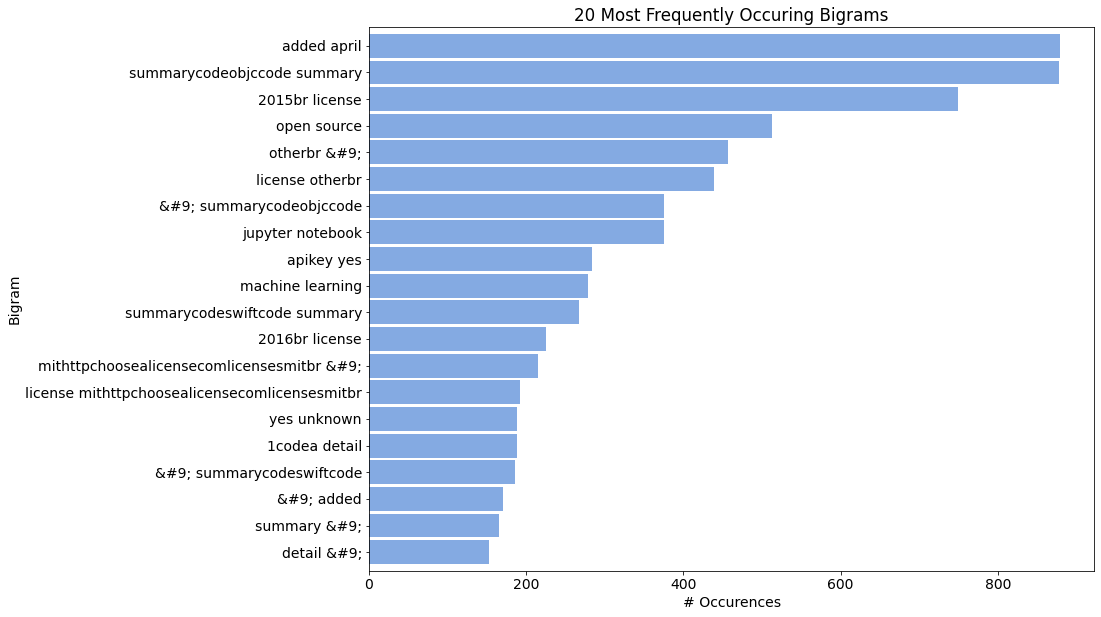

In [144]:
c="#84aae2"


top_20_js_bigrams.sort_values().plot.barh(color=c, width=.9, figsize=(13, 10))
plt.title('20 Most Frequently Occuring Java Script Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurences')
# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_js_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)
plt.show()


top_20_p_bigrams.sort_values().plot.barh(color=c, width=.9, figsize=(13, 10))
plt.title('20 Most Frequently Occuring Python Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurences')
# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_p_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)
plt.show()

top_20_j_bigrams.sort_values().plot.barh(color=c, width=.9, figsize=(13,10))
plt.title('20 Most Frequently Occuring Java Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurences')
# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_j_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)
plt.show()

top_20_cpp_bigrams.sort_values().plot.barh(color=c, width=.9, figsize=(13,10))
plt.title('20 Most Frequently Occuring C++ Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurences')
# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_cpp_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)
plt.show()

top_20_bigrams.sort_values().plot.barh(color=c, width=.9, figsize=(13,10))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurences')
# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)
plt.show()

# Word Clouds

In [151]:
def word_cloud(text):
    plt.figure(figsize=(13, 13))

    cloud = WordCloud(background_color='white', height=1000, width=1000).generate(' '.join(text))

    plt.imshow(cloud)
    plt.axis('off')

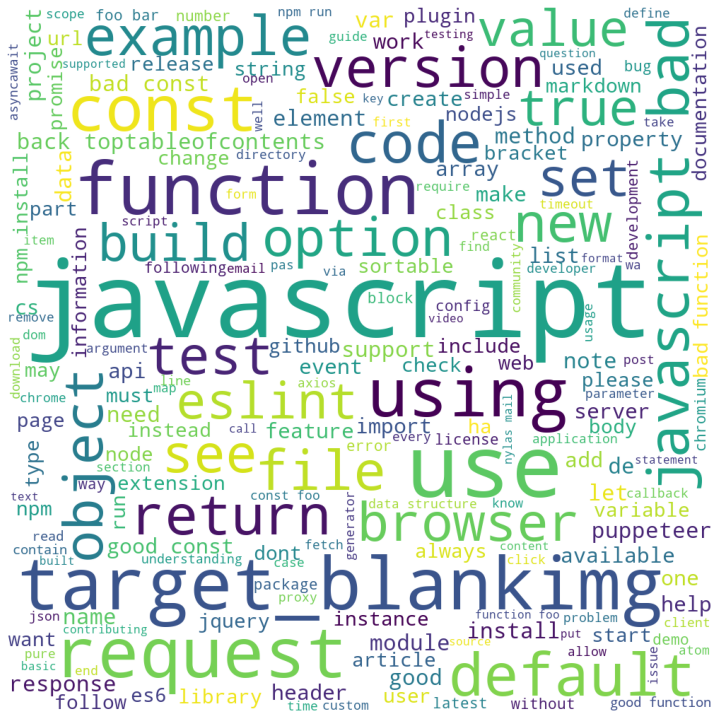

In [153]:
word_cloud(js_words)

(-0.5, 999.5, 999.5, -0.5)

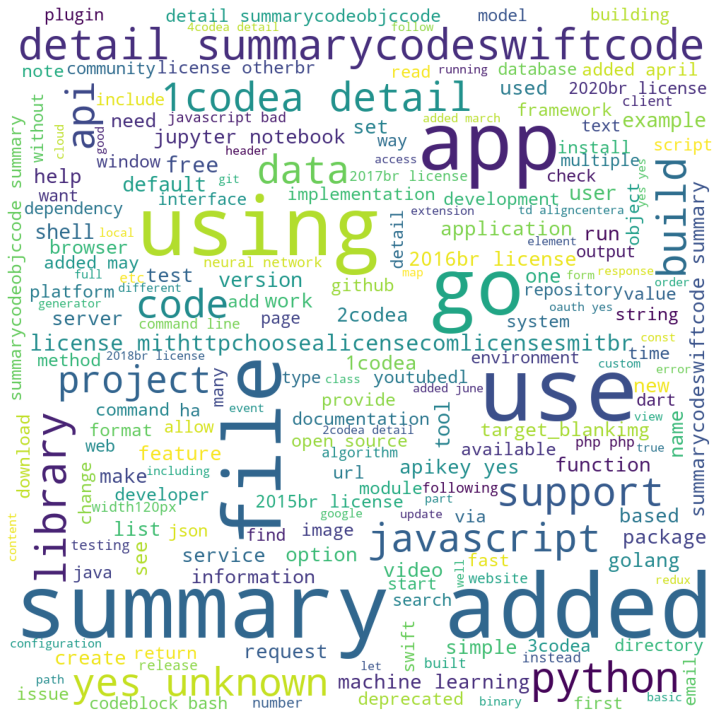

In [150]:

plt.figure(figsize=(13, 13))

all_cloud = WordCloud(background_color='white', height=1000, width=1000).generate(' '.join(all_words))

plt.imshow(all_cloud)
plt.axis('off')